In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

In [12]:
client = bigquery.Client()

query = """
SELECT *
FROM saneamentobasicobrasil-456115.saneamento_br.dado_saneamento_limmpos
"""

df_saneamento = client.query(query).to_dataframe()

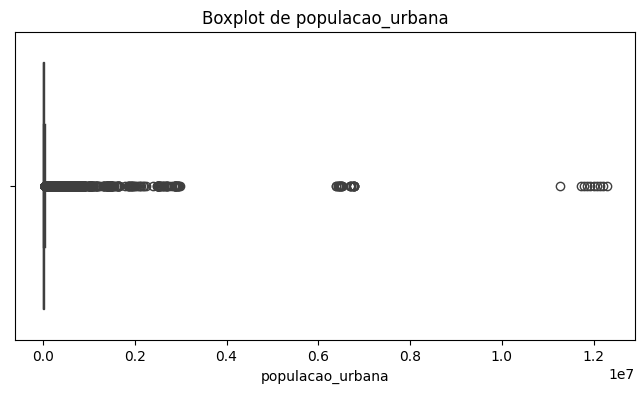

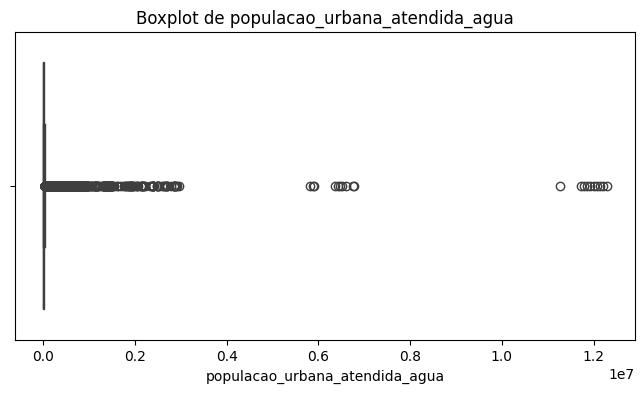

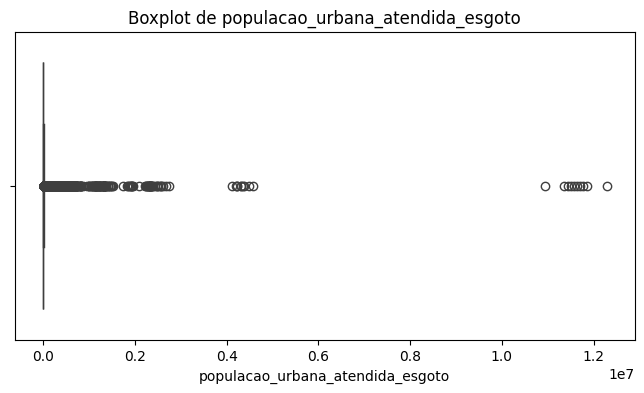

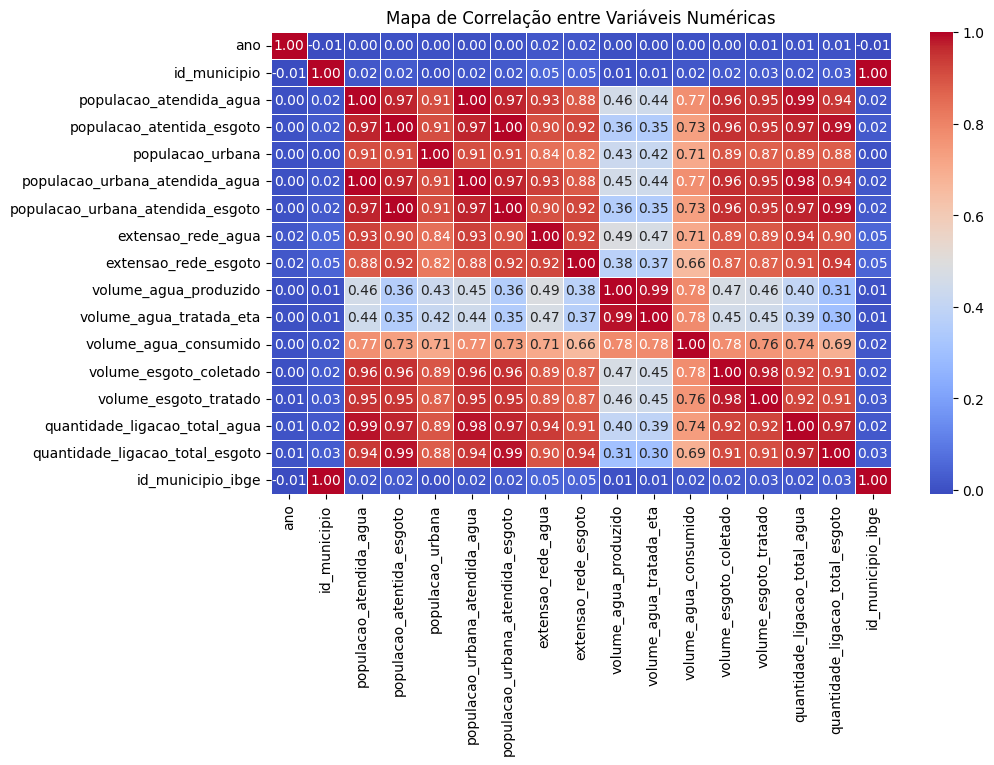

In [18]:
# busca por out
colunas_analisadas = ['populacao_urbana', 'populacao_urbana_atendida_agua', 'populacao_urbana_atendida_esgoto']

for coluna in colunas_analisadas:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_saneamento[coluna])
    plt.title(f'Boxplot de {coluna}')
    plt.show()


# Calcular a correlação entre colunas numéricas
correlacao = df_saneamento.corr(numeric_only=True)

# Cria o mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlação entre Variáveis Numéricas')
plt.show()

In [25]:
# verificar municipios fora do parão

outliers_pop_urbana = df_saneamento[df_saneamento['populacao_urbana'] > 1e7]
outliers_pop_urbana_a = df_saneamento[df_saneamento['populacao_urbana_atendida_agua'] > 1e7]
outliers_pop_urbana_e = df_saneamento[df_saneamento['populacao_urbana_atendida_esgoto'] > 1e7]

print('Outliers popução urbana', outliers_pop_urbana['nome_municipio'].unique())
print('Outliers popução urbana atendida - água', outliers_pop_urbana_a['nome_municipio'].unique())
print('Outliers popução urbana atendida - esgoto',outliers_pop_urbana_e['nome_municipio'].unique())

Outliers popução urbana ['São Paulo']
Outliers popução urbana atendida - água ['São Paulo']
Outliers popução urbana atendida - esgoto ['São Paulo']


In [13]:
# Calcular a evolução anual da cobertura de água e esgoto (% da população urbana atendida)
df_ano = df_saneamento.groupby('ano').agg({
    'populacao_urbana': 'sum',
    'populacao_urbana_atendida_agua': 'sum',
    'populacao_urbana_atendida_esgoto': 'sum',
    }).reset_index()


df_ano['crescimento_populacao_urbana'] = df_ano['populacao_urbana'].pct_change()
crescimento_recentes = df_ano['crescimento_populacao_urbana'].iloc[-3:]
media_estimada = crescimento_recentes.mean()

print(f'Média de crescimento estimada: {media_estimada*100:.2f}% ao ano.' )

df_ano['indice_agua'] = df_ano['populacao_urbana_atendida_agua'] / df_ano['populacao_urbana']
df_ano['indice_esgoto'] = df_ano['populacao_urbana_atendida_esgoto'] / df_ano['populacao_urbana']

df_ano.fillna(0, inplace=True)
print(df_ano.to_string())


Média de crescimento estimada: 5.01% ao ano.
    ano  populacao_urbana  populacao_urbana_atendida_agua  populacao_urbana_atendida_esgoto  crescimento_populacao_urbana  indice_agua  indice_esgoto
0  2012         174727334                       149428821                          89878014                           0.0     0.855211        0.51439
1  2013         179886810                       153923697                          93224152                      0.029529      0.85567       0.518238
2  2014         182499676                       156351141                          96785251                      0.014525      0.85672       0.530331
3  2015         183949008                       157222555                          98025028                      0.007942     0.854707       0.532892
4  2016         186003236                       158861494                         102082969                      0.011167     0.854079       0.548824
5  2017         186929325                       1599251

In [14]:
indice_recente_agua = df_ano['indice_agua'].iloc[-1]
indice_recente_esgoto = df_ano['indice_esgoto'].iloc[-1]
ano_recente = df_ano['ano'].iloc[-1]

crescimento_agua = df_ano['indice_agua'].pct_change().iloc[5:].mean()
crescimento_esgoto = df_ano['indice_esgoto'].pct_change().iloc[-5:].mean()

print(f'Índice atual água: {indice_recente_agua}')
print(f'Crescimento médio água: {crescimento_agua}')
print(f'Índice atual esgoto: {indice_recente_esgoto}')
print(f'Crescimento médio esgoto: {crescimento_esgoto}')

indice_alvo = 1.0

anos_agua = 0

indice_proj_agua = indice_recente_agua
while indice_proj_agua < indice_alvo and anos_agua < 500:
  indice_proj_agua *= (1+crescimento_agua)
  anos_agua += 1

anos_esgoto = 0
indice_proj_esgoto = indice_recente_esgoto
while indice_proj_esgoto < indice_alvo and anos_agua < 500:
  indice_proj_esgoto *= (1+crescimento_esgoto)
  anos_esgoto += 1

print(f'Previsão de atendimento total de água para população urbana: {ano_recente + anos_agua}')
print(f'Previsão de atendimento total de esgoto para população urbana: {ano_recente + anos_esgoto}')

Índice atual água: 0.7663243763424015
Crescimento médio água: -0.020815417495989075
Índice atual esgoto: 0.525550698217499
Crescimento médio esgoto: -0.007975170536794285
Previsão de atendimento total de água para população urbana: 2521
Previsão de atendimento total de esgoto para população urbana: 2021
